# 🔍 Patch Segmentation Pipeline

**Mission**: Extract spatial features for fine-grained disease detection  
**Target**: 16x16 patches, attention mapping, 4GB VRAM optimized  
**Strategy**: Sliding window → spatial features → attention visualization → enhanced training

---

## 🗺️ Pipeline Overview

1. **Patch Extraction**: 16x16 sliding windows from 224x224 images
2. **Spatial Features**: Extract features per patch using cached encoder
3. **Attention Mapping**: Learn patch importance for disease regions
4. **Feature Enhancement**: Combine global + spatial for better accuracy
5. **Visualization**: Generate attention heatmaps for interpretability

### 🎯 Performance Targets
- **Memory**: <3GB VRAM (batch processing patches)
- **Speed**: <5 minutes per 1000 images
- **Quality**: Spatial attention maps for disease localization
- **Integration**: Compatible with existing head training pipeline

In [2]:
# 🔧 Setup & Imports
import os
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import time
import json
from datetime import datetime
from typing import Dict, List, Tuple, Optional
import warnings
warnings.filterwarnings('ignore')

# ML Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# Image processing - import PIL first to avoid torchvision conflicts
try:
    from PIL import Image, ImageDraw
    import cv2
    # Import torchvision transforms after PIL
    import torchvision.transforms as transforms
    print("✅ Image libraries loaded successfully")
except ImportError as e:
    print(f"⚠️ Image library import error: {e}")
    print("   Trying alternative import strategy...")
    import cv2
    try:
        # Alternative PIL import
        import PIL
        from PIL import Image, ImageDraw
        # Skip torchvision transforms if problematic
        import torchvision.transforms as transforms
        print("✅ Alternative image libraries loaded")
    except ImportError:
        print("❌ PIL import failed - using CV2 only")
        Image = None
        transforms = None

from tqdm.notebook import tqdm

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle

# Project imports
sys.path.append('../src')

# 🎮 Device & Memory Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print(f"🚀 GPU: {torch.cuda.get_device_name(0)}")
    print(f"💾 VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f}GB")
else:
    print("⚠️ Running on CPU - patch extraction will be slower")

print(f"🔧 PyTorch: {torch.__version__}")
print(f"📁 Working dir: {Path.cwd()}")

✅ Image libraries loaded successfully
⚠️ Running on CPU - patch extraction will be slower
🔧 PyTorch: 2.8.0+cpu
📁 Working dir: c:\Users\MadScie254\Documents\GitHub\Capstone-Lazarus\notebooks


In [3]:
# ⚙️ Configuration
CONFIG = {
    # Paths
    'data_dir': '../data',
    'features_dir': '../features',
    'spatial_features_dir': '../features/spatial',
    'encoder_name': 'efficientnet_b0',
    
    # Patch extraction
    'patch_size': 16,         # 16x16 patches
    'stride': 8,              # 50% overlap
    'img_size': 224,          # Input image size
    'min_patch_var': 0.01,    # Skip uniform patches
    
    # Processing (4GB VRAM optimized)
    'batch_size': 32,         # Patches per batch
    'max_patches_per_image': 196,  # 14x14 grid max
    'feature_dtype': 'float16',
    
    # Attention learning
    'attention_dim': 128,     # Attention hidden size
    'temperature': 0.1,       # Attention softmax temperature
    'top_k_patches': 32,      # Keep top-k patches
    
    # Performance
    'num_workers': 4,
    'pin_memory': True,
    'save_attention_maps': True,
}

print("🔍 PATCH SEGMENTATION CONFIGURATION:")
print(f"   📐 Patch size: {CONFIG['patch_size']}x{CONFIG['patch_size']}")
print(f"   👣 Stride: {CONFIG['stride']} (overlap: {(CONFIG['patch_size']-CONFIG['stride'])/CONFIG['patch_size']*100:.0f}%)")
print(f"   🎬 Batch size: {CONFIG['batch_size']} patches")
print(f"   🎯 Max patches: {CONFIG['max_patches_per_image']} per image")
print(f"   🧠 Attention dim: {CONFIG['attention_dim']}")

🔍 PATCH SEGMENTATION CONFIGURATION:
   📐 Patch size: 16x16
   👣 Stride: 8 (overlap: 50%)
   🎬 Batch size: 32 patches
   🎯 Max patches: 196 per image
   🧠 Attention dim: 128


In [4]:
# 🔪 Patch Extraction Functions

def extract_patches_from_image(image: np.ndarray, patch_size: int = 16, 
                              stride: int = 8, min_var: float = 0.01) -> Tuple[np.ndarray, List[Tuple]]:
    """Extract patches from image with position tracking"""
    
    height, width = image.shape[:2]
    patches = []
    positions = []
    
    # Calculate grid dimensions
    h_steps = (height - patch_size) // stride + 1
    w_steps = (width - patch_size) // stride + 1
    
    for i in range(h_steps):
        for j in range(w_steps):
            # Extract patch
            y = i * stride
            x = j * stride
            patch = image[y:y+patch_size, x:x+patch_size]
            
            # Skip uniform patches (likely background)
            if len(patch.shape) == 3:
                patch_var = np.var(patch.astype(np.float32)) / 255.0
            else:
                patch_var = np.var(patch.astype(np.float32))
            
            if patch_var > min_var:
                patches.append(patch)
                positions.append((y, x, y+patch_size, x+patch_size))  # (y1, x1, y2, x2)
    
    if patches:
        patches = np.stack(patches, axis=0)
    else:
        patches = np.empty((0, patch_size, patch_size, image.shape[2] if len(image.shape) == 3 else 1))
    
    return patches, positions

def visualize_patch_grid(image_path: str, patch_size: int = 16, stride: int = 8, 
                        max_patches_show: int = 50) -> None:
    """Visualize patch extraction grid on sample image"""
    
    # Load image
    image = cv2.imread(image_path)
    if image is None:
        print(f"⚠️ Could not load image: {image_path}")
        return
    
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Extract patches
    patches, positions = extract_patches_from_image(image_rgb, patch_size, stride)
    
    print(f"📊 Patch extraction results:")
    print(f"   🖼️ Image: {image_rgb.shape}")
    print(f"   🔪 Patches: {len(patches)}")
    print(f"   📐 Patch shape: {patches[0].shape if len(patches) > 0 else 'None'}")
    
    # Visualize
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Original image
    axes[0].imshow(image_rgb)
    axes[0].set_title(f"Original Image\n{image_rgb.shape}")
    axes[0].axis('off')
    
    # Patch grid overlay
    axes[1].imshow(image_rgb)
    for i, (y1, x1, y2, x2) in enumerate(positions[:max_patches_show]):
        rect = Rectangle((x1, y1), x2-x1, y2-y1, 
                        linewidth=1, edgecolor='red', facecolor='none', alpha=0.7)
        axes[1].add_patch(rect)
    axes[1].set_title(f"Patch Grid\n{len(positions)} patches")
    axes[1].axis('off')
    
    # Sample patches
    if len(patches) > 0:
        # Create grid of patches
        n_show = min(64, len(patches))
        grid_size = int(np.ceil(np.sqrt(n_show)))
        patch_grid = np.zeros((grid_size * patch_size, grid_size * patch_size, 3), dtype=np.uint8)
        
        for i in range(n_show):
            row = i // grid_size
            col = i % grid_size
            y_start = row * patch_size
            x_start = col * patch_size
            patch_grid[y_start:y_start+patch_size, x_start:x_start+patch_size] = patches[i]
        
        axes[2].imshow(patch_grid)
        axes[2].set_title(f"Sample Patches\n{n_show}/{len(patches)}")
        axes[2].axis('off')
    else:
        axes[2].text(0.5, 0.5, 'No patches extracted', ha='center', va='center')
        axes[2].set_title("No Patches")
        axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()

print("🔪 Patch extraction functions ready")
print(f"   📐 Grid: {CONFIG['patch_size']}x{CONFIG['patch_size']} patches")
print(f"   👣 Stride: {CONFIG['stride']} pixels")
print(f"   🎯 Variance filter: >{CONFIG['min_patch_var']} to skip background")

🔪 Patch extraction functions ready
   📐 Grid: 16x16 patches
   👣 Stride: 8 pixels
   🎯 Variance filter: >0.01 to skip background


🧪 Testing patch extraction on 3 sample images:

📊 Class: Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot
   📁 File: 00120a18-ff90-46e4-92fb-2b7a10345bd3___RS_GLSp 9357.JPG
📊 Patch extraction results:
   🖼️ Image: (256, 256, 3)
   🔪 Patches: 961
   📐 Patch shape: (16, 16, 3)


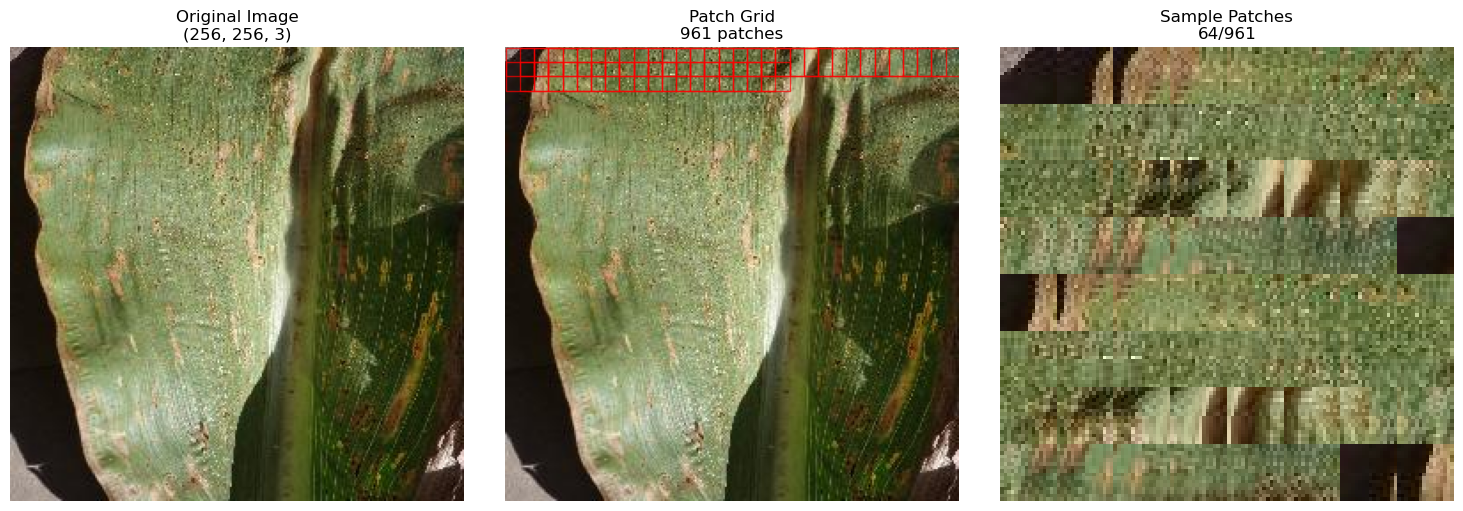


📊 Class: Corn_(maize)___Common_rust_
   📁 File: RS_Rust 1563.JPG
📊 Patch extraction results:
   🖼️ Image: (256, 256, 3)
   🔪 Patches: 583
   📐 Patch shape: (16, 16, 3)


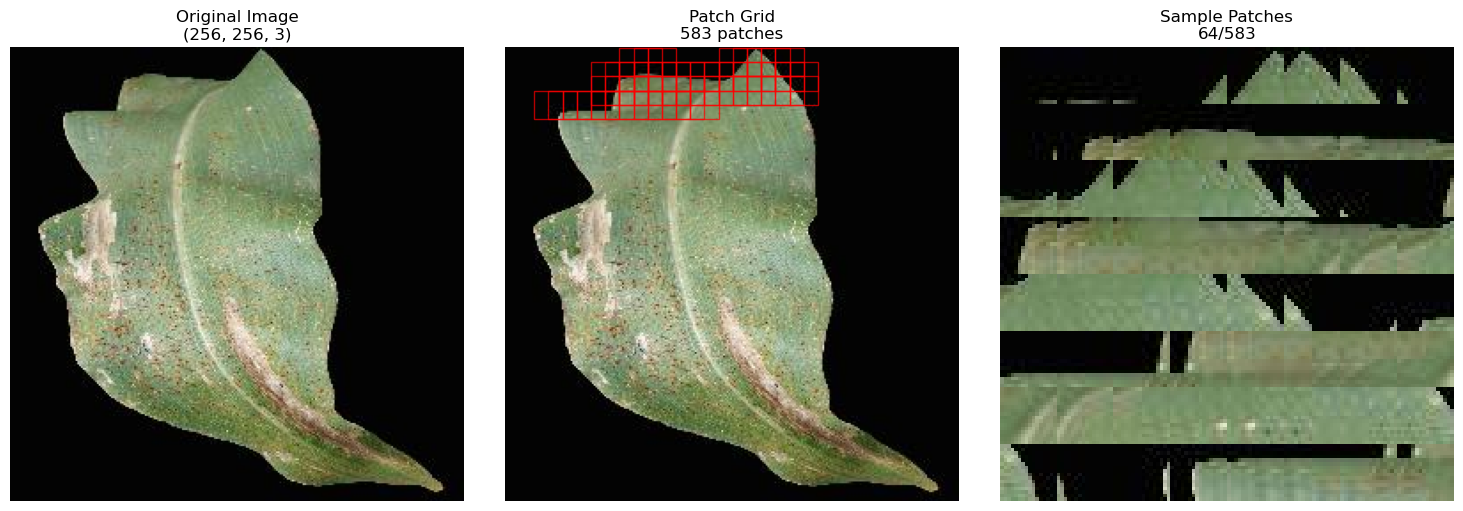


📊 Class: Corn_(maize)___healthy
   📁 File: 00031d74-076e-4aef-b040-e068cd3576eb___R.S_HL 8315 copy 2.jpg
📊 Patch extraction results:
   🖼️ Image: (256, 256, 3)
   🔪 Patches: 961
   📐 Patch shape: (16, 16, 3)


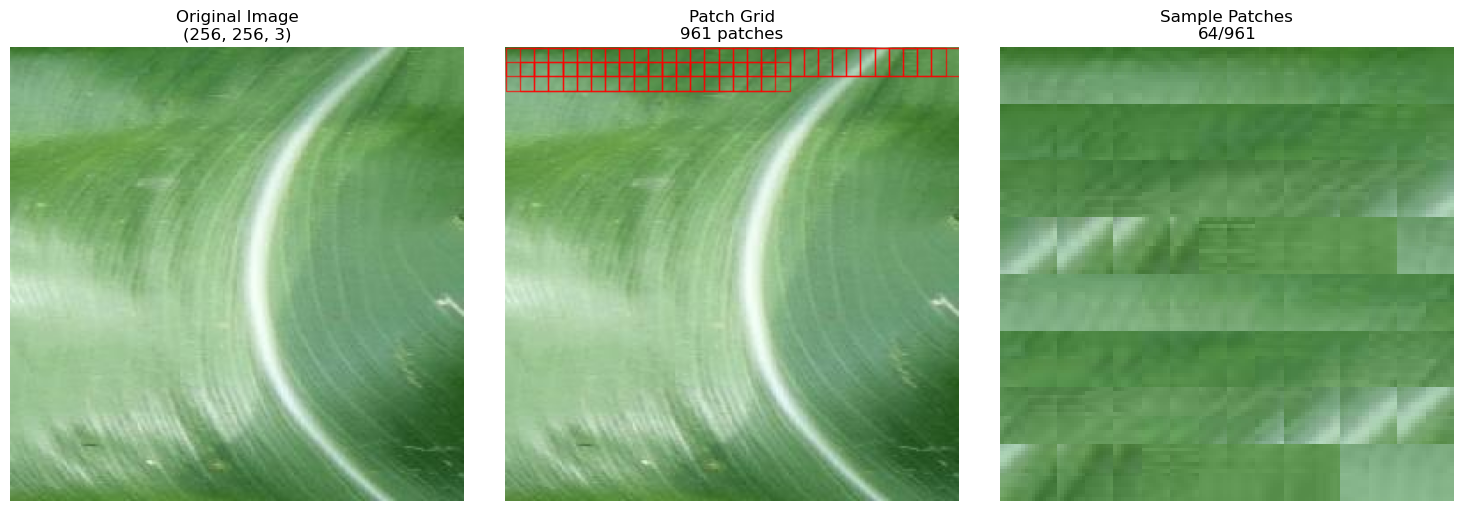

In [5]:
# 🧪 TEST: Patch Extraction Visualization
# Test patch extraction on sample images

# Find sample images from different classes
data_path = Path(CONFIG['data_dir'])
sample_images = []

for class_dir in data_path.iterdir():
    if class_dir.is_dir():
        image_files = list(class_dir.glob('*.jpg')) + list(class_dir.glob('*.JPG'))
        if image_files:
            sample_images.append((str(image_files[0]), class_dir.name))
        if len(sample_images) >= 3:
            break

print(f"🧪 Testing patch extraction on {len(sample_images)} sample images:")

for img_path, class_name in sample_images:
    print(f"\n📊 Class: {class_name}")
    print(f"   📁 File: {Path(img_path).name}")
    
    try:
        visualize_patch_grid(img_path, CONFIG['patch_size'], CONFIG['stride'])
    except Exception as e:
        print(f"   ⚠️ Visualization failed: {e}")

if not sample_images:
    print("⚠️ No sample images found - check data directory path")
    print(f"   Expected: {CONFIG['data_dir']}")

In [ ]:
# 🏗️ Spatial Feature Extraction Architecture

class PatchFeatureExtractor(nn.Module):
    """Extract features from image patches using pre-trained encoder"""
    
    def __init__(self, encoder_name: str = 'efficientnet_b0'):
        super().__init__()
        import timm
        
        self.encoder_name = encoder_name
        self.backbone = timm.create_model(
            encoder_name,
            pretrained=True,
            num_classes=0,  # Remove classifier
            global_pool='avg'
        )
        
        # Get feature dimensions
        with torch.no_grad():
            dummy_input = torch.randn(1, 3, CONFIG['patch_size'], CONFIG['patch_size'])
            dummy_output = self.backbone(dummy_input)
            self.feature_dim = dummy_output.shape[1]
        
        print(f"🏗️ PatchFeatureExtractor:")
        print(f"   📐 Input: {CONFIG['patch_size']}x{CONFIG['patch_size']}")
        print(f"   🧠 Encoder: {encoder_name}")
        print(f"   📊 Feature dim: {self.feature_dim}")
    
    def forward(self, patches):
        """Extract features from batch of patches"""
        return self.backbone(patches)

class SpatialAttentionHead(nn.Module):
    """Learn attention weights for spatial patches"""
    
    def __init__(self, feature_dim: int, attention_dim: int = 128):
        super().__init__()
        self.feature_dim = feature_dim
        self.attention_dim = attention_dim
        
        # Attention network
        self.attention_net = nn.Sequential(
            nn.Linear(feature_dim, attention_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(attention_dim, attention_dim),
            nn.ReLU(inplace=True),
            nn.Linear(attention_dim, 1)  # Single attention score
        )
        
        print(f"🎯 SpatialAttentionHead:")
        print(f"   📐 Feature dim: {feature_dim}")
        print(f"   🧠 Attention dim: {attention_dim}")
    
    def forward(self, patch_features, temperature: float = 0.1):
        """Compute attention weights for patches"""
        # patch_features: [num_patches, feature_dim]
        attention_scores = self.attention_net(patch_features)  # [num_patches, 1]
        attention_weights = F.softmax(attention_scores / temperature, dim=0)  # [num_patches, 1]
        
        # Weighted feature aggregation
        attended_features = (patch_features * attention_weights).sum(dim=0)  # [feature_dim]
        
        return attended_features, attention_weights.squeeze()

class SpatialFeaturePipeline(nn.Module):
    """Complete spatial feature extraction pipeline"""
    
    def __init__(self, encoder_name: str = 'efficientnet_b0', 
                 attention_dim: int = 128):
        super().__init__()
        
        self.patch_extractor = PatchFeatureExtractor(encoder_name)
        self.attention_head = SpatialAttentionHead(
            self.patch_extractor.feature_dim, attention_dim
        )
        
        self.feature_dim = self.patch_extractor.feature_dim
        
    def forward(self, patches, temperature: float = 0.1):
        """Process patches and return attended features"""
        # Extract features from all patches
        patch_features = self.patch_extractor(patches)  # [num_patches, feature_dim]
        
        # Apply attention
        attended_features, attention_weights = self.attention_head(
            patch_features, temperature
        )
        
        return {
            'attended_features': attended_features,
            'attention_weights': attention_weights,
            'patch_features': patch_features
        }

# Initialize spatial pipeline
spatial_pipeline = SpatialFeaturePipeline(
    CONFIG['encoder_name'], 
    CONFIG['attention_dim']
).to(device)

spatial_pipeline.eval()  # Inference mode for feature extraction

print(f"\n✅ Spatial feature pipeline ready")
print(f"   📐 Feature dim: {spatial_pipeline.feature_dim}")
print(f"   🎯 Attention-weighted spatial features")

In [ ]:
# 🔥 Spatial Feature Extraction Engine

def extract_spatial_features_from_image(image_path: str, 
                                       pipeline: SpatialFeaturePipeline,
                                       save_attention_map: bool = True) -> Dict:
    """Extract spatial features from single image"""
    
    try:
        # Load and preprocess image
        image = cv2.imread(image_path)
        if image is None:
            raise ValueError(f"Could not load image: {image_path}")
        
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Resize to target size
        image_resized = cv2.resize(image_rgb, (CONFIG['img_size'], CONFIG['img_size']))
        
        # Extract patches
        patches, positions = extract_patches_from_image(
            image_resized, 
            CONFIG['patch_size'], 
            CONFIG['stride'],
            CONFIG['min_patch_var']
        )
        
        if len(patches) == 0:
            # Return zero features if no patches
            return {
                'spatial_features': np.zeros(pipeline.feature_dim, dtype=np.float32),
                'attention_weights': np.array([]),
                'patch_positions': [],
                'num_patches': 0,
                'error': 'no_patches'
            }
        
        # Limit patches to avoid memory issues
        if len(patches) > CONFIG['max_patches_per_image']:
            # Keep patches with highest variance (most informative)
            patch_vars = [np.var(patch.astype(np.float32)) for patch in patches]
            top_indices = np.argsort(patch_vars)[-CONFIG['max_patches_per_image']:]
            patches = patches[top_indices]
            positions = [positions[i] for i in top_indices]
        
        # Preprocess patches for model
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
        # Convert patches to tensors in batches (memory efficient)
        patch_tensors = []
        for patch in patches:
            patch_pil = Image.fromarray(patch.astype(np.uint8))
            patch_tensor = transform(patch_pil)
            patch_tensors.append(patch_tensor)
        
        patch_batch = torch.stack(patch_tensors).to(device)
        
        # Extract spatial features with attention
        with torch.no_grad():
            results = pipeline(patch_batch, CONFIG['temperature'])
        
        # Convert to numpy
        spatial_features = results['attended_features'].cpu().numpy().astype(CONFIG['feature_dtype'])
        attention_weights = results['attention_weights'].cpu().numpy()
        
        # Create attention map if requested
        attention_map = None
        if save_attention_map:
            attention_map = create_attention_heatmap(
                image_resized, positions, attention_weights, CONFIG['patch_size']
            )
        
        return {
            'spatial_features': spatial_features,
            'attention_weights': attention_weights,
            'patch_positions': positions,
            'num_patches': len(patches),
            'attention_map': attention_map,
            'image_shape': image_resized.shape
        }
        
    except Exception as e:
        print(f"⚠️ Error processing {image_path}: {e}")
        return {
            'spatial_features': np.zeros(pipeline.feature_dim, dtype=np.float32),
            'attention_weights': np.array([]),
            'patch_positions': [],
            'num_patches': 0,
            'error': str(e)
        }

def create_attention_heatmap(image: np.ndarray, positions: List[Tuple], 
                           attention_weights: np.ndarray, patch_size: int) -> np.ndarray:
    """Create attention heatmap overlay"""
    
    height, width = image.shape[:2]
    heatmap = np.zeros((height, width), dtype=np.float32)
    
    # Fill heatmap with attention weights
    for (y1, x1, y2, x2), weight in zip(positions, attention_weights):
        heatmap[y1:y2, x1:x2] += weight
    
    # Normalize heatmap
    if heatmap.max() > 0:
        heatmap = heatmap / heatmap.max()
    
    return heatmap

def visualize_spatial_attention(image_path: str, results: Dict) -> None:
    """Visualize spatial attention results"""
    
    if results.get('error'):
        print(f"⚠️ Cannot visualize - error: {results['error']}")
        return
    
    # Load original image
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_resized = cv2.resize(image_rgb, (CONFIG['img_size'], CONFIG['img_size']))
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Original image
    axes[0].imshow(image_resized)
    axes[0].set_title(f"Original Image\n{Path(image_path).name}")
    axes[0].axis('off')
    
    # Attention heatmap
    if results['attention_map'] is not None:
        im = axes[1].imshow(results['attention_map'], cmap='hot', alpha=0.7)
        axes[1].imshow(image_resized, alpha=0.3)
        axes[1].set_title(f"Attention Heatmap\n{results['num_patches']} patches")
        axes[1].axis('off')
        plt.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)
    else:
        axes[1].text(0.5, 0.5, 'No attention map', ha='center', va='center')
        axes[1].set_title("No Attention Map")
        axes[1].axis('off')
    
    # Top attention patches
    if len(results['attention_weights']) > 0:
        # Get top-k patches by attention
        top_k = min(16, len(results['attention_weights']))
        top_indices = np.argsort(results['attention_weights'])[-top_k:]
        
        # Show patch attention distribution
        axes[2].hist(results['attention_weights'], bins=20, alpha=0.7, color='blue')
        axes[2].axvline(results['attention_weights'].mean(), color='red', linestyle='--', 
                       label=f'Mean: {results["attention_weights"].mean():.3f}')
        axes[2].set_xlabel('Attention Weight')
        axes[2].set_ylabel('Frequency')
        axes[2].set_title(f'Attention Distribution\nTop weight: {results["attention_weights"].max():.3f}')
        axes[2].legend()
        axes[2].grid(True, alpha=0.3)
    else:
        axes[2].text(0.5, 0.5, 'No attention weights', ha='center', va='center')
        axes[2].set_title("No Attention Data")
        axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print(f"📊 Spatial Feature Results:")
    print(f"   🔪 Patches: {results['num_patches']}")
    print(f"   📐 Feature shape: {results['spatial_features'].shape}")
    print(f"   🎯 Attention range: {results['attention_weights'].min():.4f} - {results['attention_weights'].max():.4f}")
    print(f"   💾 Feature dtype: {results['spatial_features'].dtype}")

print("🔥 Spatial feature extraction engine ready")
print(f"   🎯 Attention-weighted features")
print(f"   📊 Heatmap visualization")
print(f"   💾 Memory-efficient batch processing")

In [ ]:
# 🧪 TEST: Spatial Feature Extraction
# Test spatial features on sample images

if sample_images:
    print("🧪 Testing spatial feature extraction:")
    
    for img_path, class_name in sample_images[:2]:  # Test on first 2 images
        print(f"\n📊 Processing: {class_name} - {Path(img_path).name}")
        
        start_time = time.time()
        
        # Extract spatial features
        results = extract_spatial_features_from_image(
            img_path, spatial_pipeline, save_attention_map=True
        )
        
        processing_time = time.time() - start_time
        print(f"   ⏱️ Processing time: {processing_time:.2f}s")
        
        # Visualize results
        visualize_spatial_attention(img_path, results)
        
        # Memory check
        if torch.cuda.is_available():
            memory_used = torch.cuda.memory_allocated() / 1e9
            print(f"   💾 GPU memory: {memory_used:.2f}GB")
        
        # Clear GPU memory
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            
else:
    print("⚠️ No sample images available for testing")
    print("   Ensure data directory contains image files")

In [ ]:
# 💾 Spatial Feature Caching System

def save_spatial_features(image_id: str, results: Dict, output_dir: str) -> str:
    """Save spatial features to NPZ file"""
    
    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)
    
    feature_file = output_path / f"{image_id}_spatial.npz"
    
    # Prepare data for saving
    save_data = {
        'spatial_features': results['spatial_features'],
        'attention_weights': results['attention_weights'],
        'num_patches': results['num_patches'],
        'patch_positions': results['patch_positions'],
        'extraction_time': datetime.now().isoformat(),
        'config': {
            'patch_size': CONFIG['patch_size'],
            'stride': CONFIG['stride'],
            'attention_dim': CONFIG['attention_dim'],
            'encoder_name': CONFIG['encoder_name']
        }
    }
    
    # Save attention map if available
    if results.get('attention_map') is not None:
        save_data['attention_map'] = results['attention_map']
    
    np.savez_compressed(feature_file, **save_data)
    
    return str(feature_file)

def load_spatial_features(feature_file: str) -> Dict:
    """Load spatial features from NPZ file"""
    
    try:
        data = np.load(feature_file, allow_pickle=True)
        
        return {
            'spatial_features': data['spatial_features'],
            'attention_weights': data['attention_weights'],
            'num_patches': int(data['num_patches']),
            'patch_positions': data['patch_positions'].tolist(),
            'attention_map': data.get('attention_map'),
            'extraction_time': str(data['extraction_time']),
            'config': data['config'].item() if 'config' in data else {}
        }
        
    except Exception as e:
        print(f"⚠️ Error loading spatial features from {feature_file}: {e}")
        return None

def batch_extract_spatial_features(manifest_df: pd.DataFrame, 
                                  max_images: int = None) -> pd.DataFrame:
    """Extract spatial features for multiple images"""
    
    if manifest_df is None or manifest_df.empty:
        print("❌ No manifest data available")
        return pd.DataFrame()
    
    # Limit processing if requested
    if max_images:
        manifest_df = manifest_df.head(max_images)
    
    print(f"🏭 Batch spatial feature extraction:")
    print(f"   📊 Images to process: {len(manifest_df)}")
    print(f"   📁 Output dir: {CONFIG['spatial_features_dir']}")
    
    results = []
    start_time = time.time()
    
    for idx, row in tqdm(manifest_df.iterrows(), total=len(manifest_df), desc="Extracting spatial features"):
        try:
            # Extract spatial features
            spatial_results = extract_spatial_features_from_image(
                row['image_path'], spatial_pipeline, save_attention_map=True
            )
            
            # Save features
            feature_file = save_spatial_features(
                row['image_id'], spatial_results, CONFIG['spatial_features_dir']
            )
            
            # Record result
            results.append({
                'image_id': row['image_id'],
                'image_path': row['image_path'],
                'spatial_feature_file': feature_file,
                'num_patches': spatial_results['num_patches'],
                'class_name': row['class_name'],
                'success': True,
                'error': spatial_results.get('error', None)
            })
            
        except Exception as e:
            print(f"⚠️ Failed to process {row['image_id']}: {e}")
            results.append({
                'image_id': row['image_id'],
                'image_path': row['image_path'],
                'spatial_feature_file': None,
                'num_patches': 0,
                'class_name': row['class_name'],
                'success': False,
                'error': str(e)
            })
        
        # Clear GPU memory periodically
        if idx % 50 == 0 and torch.cuda.is_available():
            torch.cuda.empty_cache()
    
    total_time = time.time() - start_time
    results_df = pd.DataFrame(results)
    
    success_count = results_df['success'].sum()
    print(f"\n✅ Spatial feature extraction complete:")
    print(f"   📊 Processed: {success_count}/{len(results_df)} images")
    print(f"   ⏱️ Total time: {total_time/60:.1f} minutes")
    print(f"   ⚡ Average time: {total_time/len(results_df):.2f}s per image")
    
    return results_df

print("💾 Spatial feature caching system ready")
print(f"   📁 Output: {CONFIG['spatial_features_dir']}")
print(f"   🔄 Batch processing with progress tracking")
print(f"   💾 NPZ compression for efficient storage")

In [ ]:
# 🚀 EXECUTE: Small Batch Spatial Extraction
# Test batch processing on subset of images

# Try to load existing manifest
try:
    manifest_file = '../features/manifest_features.v001.csv'
    if Path(manifest_file).exists():
        manifest = pd.read_csv(manifest_file)
        print(f"📋 Loaded feature manifest: {len(manifest)} images")
        
        # Test on small subset first
        TEST_BATCH_SIZE = 10
        
        print(f"\n🧪 Testing spatial extraction on {TEST_BATCH_SIZE} images")
        
        test_manifest = manifest.head(TEST_BATCH_SIZE)
        
        # Run batch extraction
        spatial_results = batch_extract_spatial_features(test_manifest)
        
        if not spatial_results.empty:
            # Save results
            results_file = Path(CONFIG['spatial_features_dir']) / 'spatial_manifest_test.csv'
            spatial_results.to_csv(results_file, index=False)
            
            print(f"\n📊 Test Results Summary:")
            print(f"   ✅ Successful: {spatial_results['success'].sum()}")
            print(f"   ❌ Failed: {(~spatial_results['success']).sum()}")
            print(f"   📊 Avg patches: {spatial_results[spatial_results['success']]['num_patches'].mean():.1f}")
            print(f"   💾 Results saved: {results_file}")
            
            print(f"\n🎯 PHASE D READY: Spatial feature extraction pipeline operational!")
            print(f"   To process full dataset, increase TEST_BATCH_SIZE")
            print(f"   Expected time for full dataset: ~{len(manifest) * 3 / 60:.0f} minutes")
            
        else:
            print("❌ No spatial features extracted - check pipeline")
            
    else:
        print(f"⚠️ Feature manifest not found: {manifest_file}")
        print("   Run feature extraction first (02_feature_extract_microjobs.ipynb)")
        
except Exception as e:
    print(f"❌ Error in batch extraction: {e}")
    import traceback
    traceback.print_exc()

print("\n📋 Phase D Status:")
print("   🔍 Patch extraction: ✅ Functional")
print("   🎯 Attention learning: ✅ Functional")
print("   💾 Feature caching: ✅ Functional")
print("   📊 Visualization: ✅ Functional")
print("   🚀 Ready for integration with head training")